In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [17]:

# Load the dataset and clean it
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df_cleaned = df.dropna()
    
    # Remove customer_id since it's not important for clustering
    df_cleaned = df_cleaned.drop(columns=['customer_id'])
    
    return df_cleaned

In [18]:
def feature_engineering(df):
    # Dropping these features since they are redundant or not useful for clustering
    df = df.drop(columns=['total_purchases','discount_counts'])
    return df

In [19]:


# Show correlation matrix and pair plot to see patterns
def perform_eda(df_cleaned):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()

    sns.pairplot(df_cleaned) 
    plt.show()

In [20]:

# Scale data for better clustering performance
def scale_data(df_cleaned):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_cleaned)
    return scaled_data

In [21]:
# Find the optimal number of clusters using the elbow method
def find_optimal_clusters(scaled_data):
    inertia = []
    K = range(1, 11)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

In [22]:

# Create clusters and add cluster labels to the dataframe
def create_clusters(df_cleaned, scaled_data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    df_cleaned['Cluster'] = clusters
    
    # Reduce to 2D for visualization using PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_data)
    df_cleaned['PCA1'] = principal_components[:, 0]
    df_cleaned['PCA2'] = principal_components[:, 1]
    
    # Plot the clusters after PCA reduction
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_cleaned, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
    plt.title('Customer Segments (PCA Projection)')
    plt.show()

    return kmeans, clusters

In [23]:
# Assign human-readable labels to clusters based on behavior patterns
def assign_cluster_labels(df_cleaned):
    cluster_map = {
        df_cleaned.groupby('Cluster')['product_click'].mean().idxmax(): 'Window Shoppers',
        df_cleaned.groupby('Cluster')['avg_cart_value'].mean().idxmax(): 'High Spenders',
        df_cleaned.groupby('Cluster')['total_time_spent'].mean().idxmin(): 'Bargain Hunters'
    }

    # Map cluster numbers to segment names
    df_cleaned['Segment'] = df_cleaned['Cluster'].map(cluster_map)

    # Show the average values for each segment
    cluster_summary = df_cleaned.groupby('Segment').mean()
    print(cluster_summary)

In [24]:
# Evaluate clustering performance using silhouette score, DBI, and RMSE
def evaluate_clusters(scaled_data, clusters, kmeans):
    # Measures how tight the clusters are
    silhouette = silhouette_score(scaled_data, clusters)

    # Measures separation between clusters
    davies_bouldin = davies_bouldin_score(scaled_data, clusters)

    # Measures distance between points and cluster center
    centroids = kmeans.cluster_centers_
    distances = np.linalg.norm(scaled_data - centroids[clusters], axis=1)
    rmse = np.sqrt(np.mean(distances ** 2))
    
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies-Bouldin Index: {davies_bouldin:.3f}')
    print(f'RMSE: {rmse:.3f}')

In [25]:
file_path = 'customer_behavior_analytcis.csv'
    
# Load and clean the data
df_cleaned = load_and_clean_data(file_path)
df_cleaned_new = feature_engineering(df_cleaned)



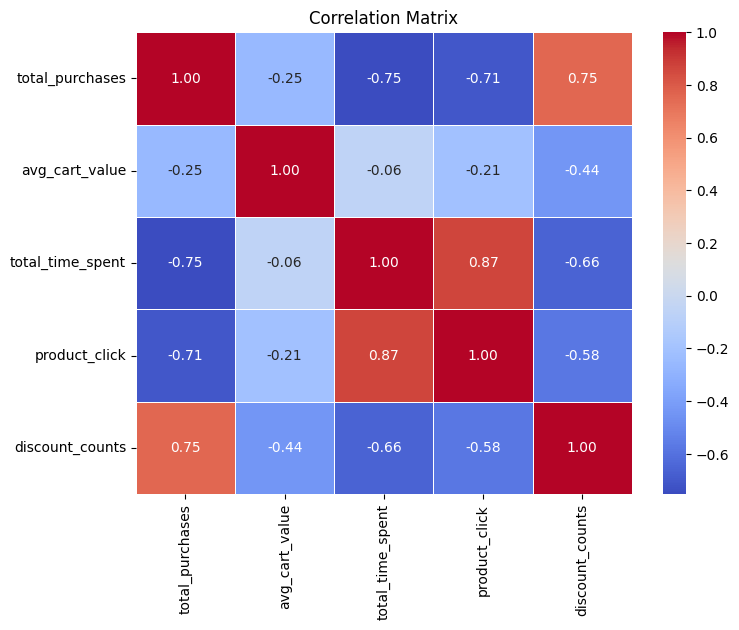

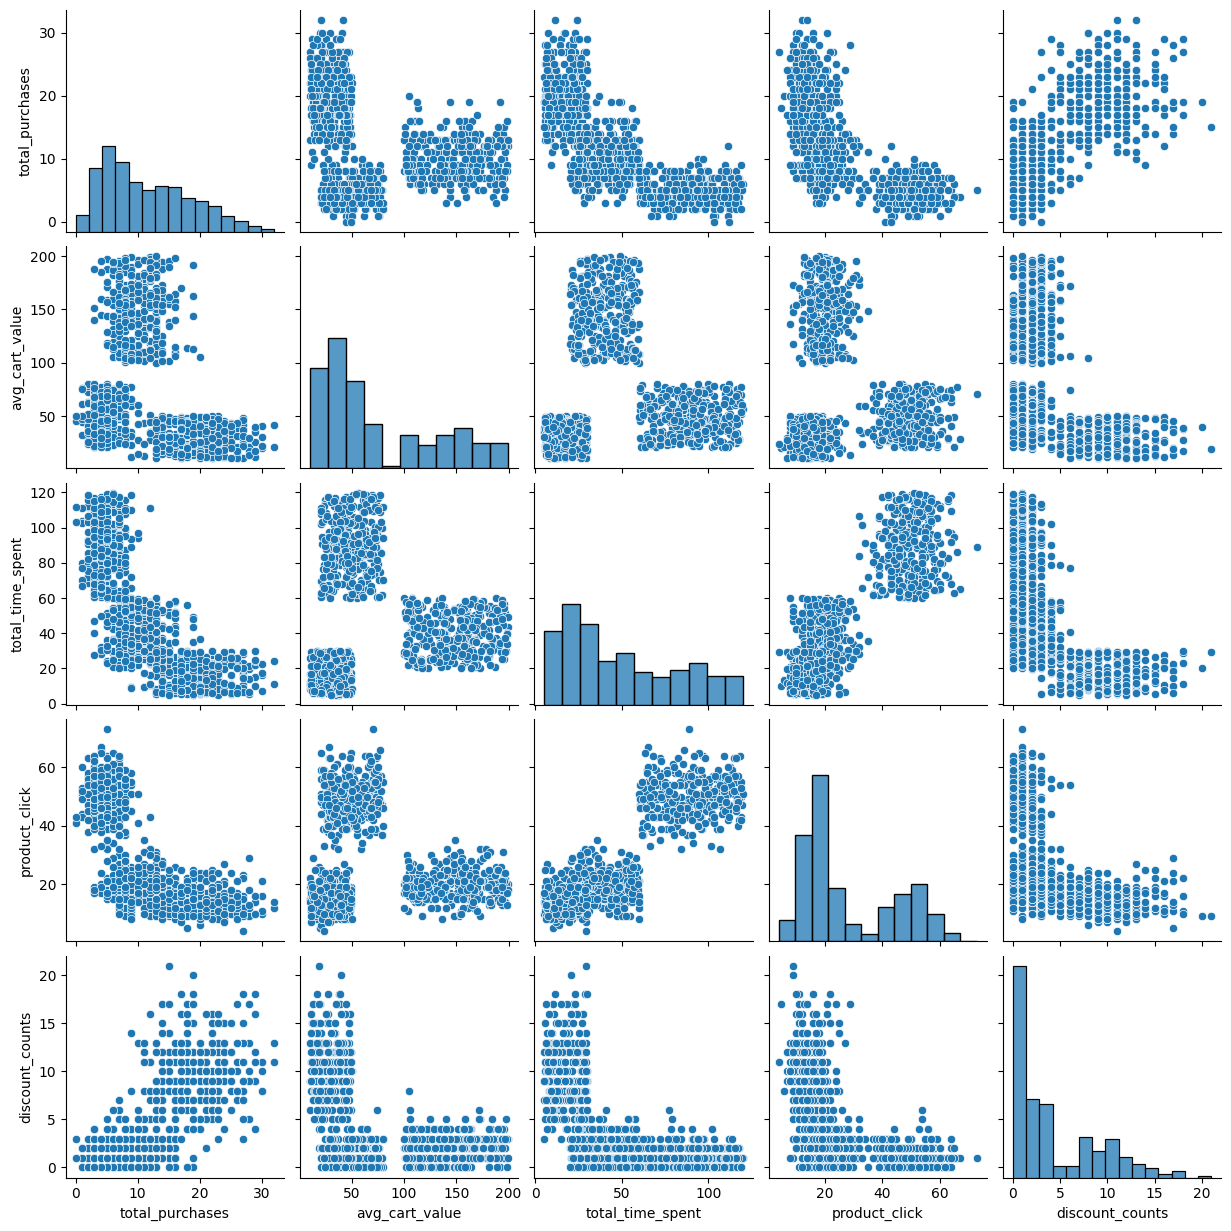

In [26]:
# Perform EDA to get a feel for the data
perform_eda(df_cleaned)



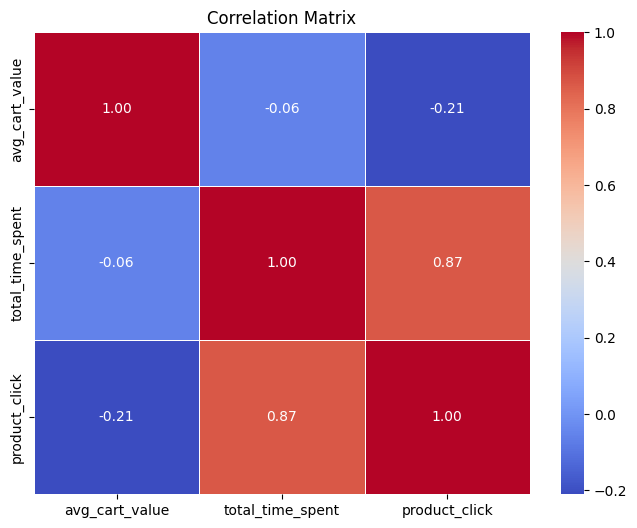

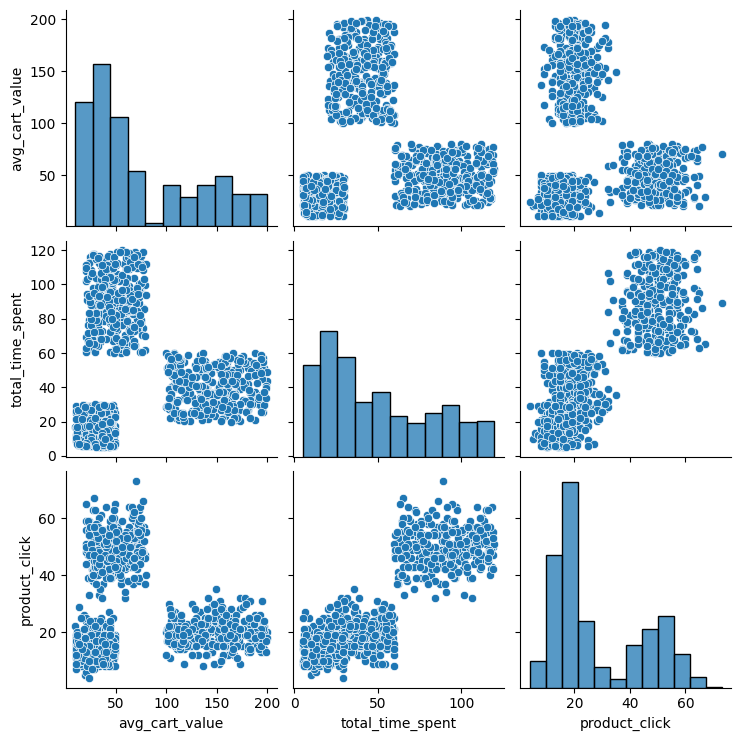

In [27]:
perform_eda(df_cleaned_new)

In [33]:

# Scale the data for clustering
scaled_data = scale_data(df_cleaned_new)



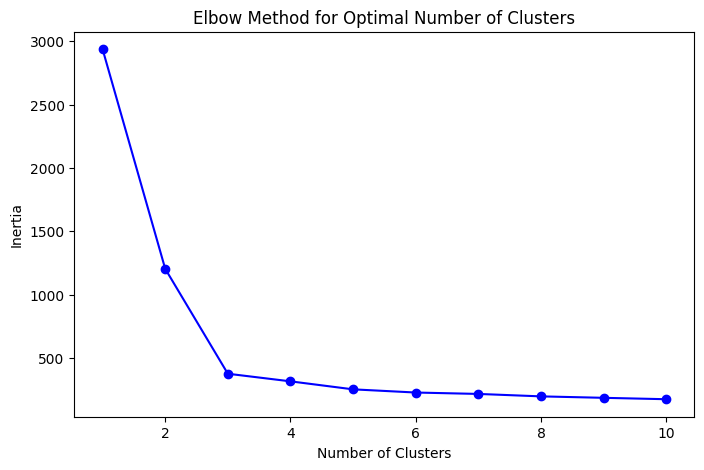

In [34]:
# Find the best number of clusters using the elbow method
find_optimal_clusters(scaled_data)



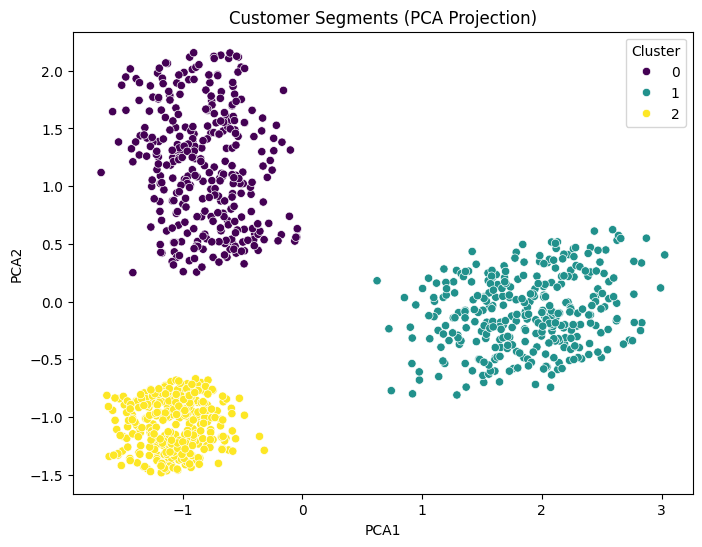

In [35]:
# Create clusters (since we know there are 3 hidden clusters)
kmeans, clusters = create_clusters(df_cleaned_new, scaled_data, n_clusters=3)



In [36]:
# Assign readable labels to clusters
assign_cluster_labels(df_cleaned_new)



                 avg_cart_value  total_time_spent  product_click  Cluster  \
Segment                                                                     
Bargain Hunters       30.399509         17.453988      14.944785      2.0   
High Spenders        147.327169         40.284369      19.895385      0.0   
Window Shoppers       49.029848         90.114726      49.716463      1.0   

                     PCA1      PCA2  
Segment                              
Bargain Hunters -1.069808 -1.068051  
High Spenders   -0.816155  1.173961  
Window Shoppers  1.871975 -0.101684  


In [37]:
# Evaluate clustering quality
evaluate_clusters(scaled_data, clusters, kmeans)

Silhouette Score: 0.684
Davies-Bouldin Index: 0.451
RMSE: 0.619
